## Task dof=1 analysis
1. The system without external forces can be described as $M \ddot q + C \dot q + g = \tau$. Now, assuming perfect compensation of the nonlinear effects $C \dot q + g$, we are left with $\ddot x - \dot J \dot q = J M^{-1} \tau$
2. Usually $\dot J \dot q \approx 0$, so we will drop the term, leaving us with $\ddot x = J M^{-1} \tau$. Given the control structure, $\tau = J^T \Lambda (k_p (x_d - x) - k_d \dot x)$, the closed loop dynamics is $\ddot x = J M^{-1} J^T \Lambda (k_p (x_d - x) - k_d \dot x)$
3. Given a 1 dof task, $J_x \triangleq J$, $J M^{-1} \triangleq [\alpha_1~\alpha_2~\dots~\alpha_n] \in \mathbb{R}^{1 \times n}$ and $J^T \Lambda (k_p (x_d - x) - k_d \dot x) \triangleq [\beta_1 \frac{\gamma_1}{s + \gamma_1}~\beta_2 \frac{\gamma_2}{s + \gamma_2}~\dots~\beta_n \frac{\gamma_1}{s + \gamma_n}]^T (k_p (x_d - x) - k_d \dot x) \in \mathbb{R}^{n \times 1}$. Note that we are making an abuse in notation here combining time and frequency domain. The overall closed loop response is $\ddot x = \sum_{j=1}^n \frac{\gamma_j}{s + \gamma_j} \alpha_j \beta_j (k_p (x_d - x) - k_d \dot x)$. Note that $\sum_{j=1}^n \alpha_j \beta_j = 1$ since $J M^{-1} J^T \Lambda = 1$
4. Assuming $x_d = 0$, we have $\ddot x + \sum_{j=1}^n \frac{\gamma_j}{s + \gamma_j} \alpha_j \beta_j (k_p x + k_d \dot x) = 0$. Taking the full laplace transform, we have $(s^2 + (\gamma_1 \alpha_1 \beta_1 k_d) \frac{s + k_p / k_d}{s + \gamma_1} + \dots + (\gamma_n \alpha_n \beta_n k_d) \frac{s + k_p / k_d}{s + \gamma_n})X(s) = 0$
5. Since there are two parameters, it can be difficult to analyze the loci of the poles. We will need to specify a reasonable value for $k_d$ and carry out our root locus analysis on $k_p$. This is because the analysis is parameterized on one single parameter.
6. Lets begin with $k_d = 0$, we thus have $\ddot x + \sum_{j=1}^n \frac{\gamma_j}{s + \gamma_j} \alpha_j \beta_j k_p x = 0$. Taking the laplace transform, we have $(s^2 + \frac{\gamma_1 \alpha_1 \beta_1 k_p}{s + \gamma_1} + \dots + \frac{\gamma_n \alpha_n \beta_n k_p}{s + \gamma_n})X(s) = 0$. Converting it to the usual root locus characteristic equation, we have $1 + k_p \frac{\frac{\gamma_1 \alpha_1 \beta_1}{s + \gamma_1} + \dots + \frac{\gamma_n \alpha_n \beta_n}{s + \gamma_n}}{s^2} = 0$
7. Now, instead of using a variable damping as specified by $k_d$, we will use a fixed damping gain $b$ for all the configurations to simplify our analysis. The above characteristic equation yields $1 + k_p \frac{\frac{\gamma_1 \alpha_1 \beta_1}{s + \gamma_1} + \dots + \frac{\gamma_n \alpha_n \beta_n}{s + \gamma_n}}{s^2 + bs} = 0$. This puts an additional pole at $s=-b$, effectively 'pulling' the loci to the right, thus improving stability.

#### Data generation
1. We will run simulations with $2^7 = 128$ configurations and gather the weights, i.e. the elements $\alpha_i \beta_i = [J_x \bar J_x]_i$
2. The wrist configuration, i.e. whether it is intersecting, can be editted using the *URDF* definition. *kuka_iiwa.urdf* describes a robot with intersecting axes while *kuka_iiwa_offset.urdf* describes a robot that has non-intersecting A6 and A7 just like our current robot arm.
3. To move the TCP away from the last joint's frame, a non-zero *tcp_offset_from_wrist_center* can be used

In [1]:
import itertools

import pybullet as b
import time
import pybullet_data

import eigen as e
import rbdyn as rbd
import sva as s
import numpy as np
from rbdyn.parsers import *

URDF = "./resource/kuka_iiwa_offset.urdf" #flexiv wrist
# URDF = "./resource/kuka_iiwa.urdf"

# pose
# tcp_offset_from_wrist_center = e.Vector3d(0.15,0.15,0.15)
tcp_offset_from_wrist_center = e.Vector3d(0,0,0)

def skew(v):
    '''Gets the skew symmetric matrix of a vector
    @param v Vector to be operated
    @return Skew symmetric matrix
    '''
    sv = e.Matrix3d()
    sv.setZero()
    
    sv.coeff(0,1,-v[2])
    sv.coeff(1,0,v[2])
        
    sv.coeff(0,2,v[1])
    sv.coeff(2,0,-v[1])

    sv.coeff(1,2,-v[0])
    sv.coeff(2,1,v[0])
    
    return sv

def body_id_from_name(name, bodies):
    '''Gets the body Id from the body name
    @param name The name of the body
    @param bodies The set of bodies provided by the multibody data structure
    @return Id of the body, -1 if not found
    '''
    for bi, b in enumerate(bodies):
        if (b.name().decode("utf-8") == name):
            return bi
    return -1

def sva_to_affine(s):
    '''Converts a spatial transform matrix to a homogeneous transform matrix
    @param s Spatial transform
    @return Homogeneous transform matrix
    '''
    m4d = e.Matrix4d.Identity()
    R = s.rotation().transpose()
    p = s.translation()
    
    for row in range(3):
        for col in range(3):
            m4d.coeff(row, col, R.coeff(row, col))
    for row in range(3):
        m4d.coeff(row, 3, p[row])
        
    return m4d

def inv_spd_sr(mat, k=1e-4):
    '''Converts an inverse into an SVD problem with singularity robust inverse
    @param mat Matrix to be inversed
    @param tolerance Tolerance to the minimum singular value that can go through reciprocal operation
    @return Homogeneous transform matrix
    '''
    mat_np = np.array(mat)
    reg = k * np.identity(np.size(mat_np,0))
    
    return e.MatrixXd(mat_np.transpose().dot(np.linalg.inv(mat_np.dot(mat_np.transpose()) + reg)))

# import robot as global variable
p = from_urdf_file(URDF)
print("Imported " + p.name.decode("utf-8") + " from " + URDF)
print("Using offset {}".format(tcp_offset_from_wrist_center.transpose()))

# setup robot and environment
p.mbc.gravity = e.Vector3d(0,0,9.81) # set gravity direction (this is the acceleration at base joint for RNEA)
p.mbc.zero(p.mb)
n_dof = p.mb.nrDof()
joints_id = range(n_dof)
body_name = "lbr_iiwa_link_7"

# setup display
physics_client = b.connect(b.GUI)
b.resetDebugVisualizerCamera(5,50,-35,[0,0,0])
b.setAdditionalSearchPath(pybullet_data.getDataPath())
plane_id = b.loadURDF("plane.urdf")
robot_id = b.loadURDF(URDF,[0,0,0], b.getQuaternionFromEuler([0,0,0]), flags=b.URDF_USE_INERTIA_FROM_FILE | b.URDF_USE_SELF_COLLISION_EXCLUDE_ALL_PARENTS)

# kinematic configurations to explore, permutating between 2 values per joint
q_range = np.asarray([
[-1.5, 1.5], [-1.0, 1.0], [-1.5, 1.5], [-1.0, 1.0],
[-1.5, 1.5], [-1.5, 1.5], [-1.5, 1.5]
])
q_perm = np.asarray(list(itertools.product([0, 1], repeat=n_dof)))
q_test = np.zeros(q_perm.shape)
for i in range(q_perm.shape[0]):
    for j in range(q_perm.shape[1]):
        if q_perm[i,j] == 0:
            q_test[i,j] = q_range[j,0]
        else:
            q_test[i,j] = q_range[j,1]

# selection matrix to swap linear and angular components
S = e.MatrixXd(6,6)
S.coeff(0,3,1)
S.coeff(1,4,1)
S.coeff(2,5,1)
S.coeff(3,0,1)
S.coeff(4,1,1)
S.coeff(5,2,1)

# selection matrix to isolate sub-7dof tasks
Sx = e.MatrixXd(1,6) # task in x-axis
Sx.coeff(0,0,1)
Sxy = e.MatrixXd(2,6) # task in xy-axes
Sxy.coeff(0,0,1)
Sxy.coeff(1,1,1)

# set configuration and compute dynamics
w_arr = np.zeros(q_test.shape)

for j in range(len(q_test)):
    q = q_test[j]

    # update visuals
    for i in joints_id:
        b.resetJointState(robot_id, i, targetValue=q[i])

    # update model with dq = 0
    for i in range(0, n_dof):
        p.mbc.q[i+1][0] = q[i]
        p.mbc.alpha[i+1][0] = 0

    # forward kinematics
    rbd.forwardKinematics(p.mb, p.mbc)
    rbd.forwardVelocity(p.mb, p.mbc)

    # compute all matrices
    # jacobian, dJacobian [angular; linear]
    jac = rbd.Jacobian(p.mb, body_name.encode('utf-8'), tcp_offset_from_wrist_center)
    Jtemp = e.MatrixXd(6, n_dof)
    dJtemp = e.MatrixXd(6, n_dof)
    jac.fullJacobian(p.mb, jac.jacobian(p.mb, p.mbc), Jtemp)
    jac.fullJacobian(p.mb, jac.jacobianDot(p.mb, p.mbc), dJtemp)
    J = S*Jtemp
    dJ = S*dJtemp
    Jx = Sx*J
    Jxy = Sxy*J

    # mass matrix
    fd = rbd.ForwardDynamics(p.mb)
    fd.computeH(p.mb, p.mbc);
    M = fd.H()

    # nonlinear effects
    fd = rbd.ForwardDynamics(p.mb)
    fd.computeC(p.mb, p.mbc);
    h = fd.C()

    # compute Minv
    Minv = M.inverse()

    # compute lambda
    Lambda = inv_spd_sr(J*Minv*J.transpose(),1e-8)

    # compute Jbar
    Jbarx = Minv*Jx.transpose()*inv_spd_sr(Jx*Minv*Jx.transpose(),1e-8)
    Jbarxy = Minv*Jxy.transpose()*inv_spd_sr(Jxy*Minv*Jxy.transpose(),1e-8)

    # compute weights
    w = e.VectorXd(n_dof)
    for i in range(n_dof):
        w.coeff(i, J[0,i]*Jbarx[i,0])
    
    # store weights    
    for i in range(n_dof):
        w_arr[j,i] = np.array(w[i])
        
#     # test
#     s = p.mbc.bodyPosW[body_id_from_name("lbr_iiwa_link_7", p.mb.bodies())]
#     R0E = s.rotation().transpose()
#     p0E = s.translation()
    
#     X = e.MatrixXd(6,6)
#     for i in range(X.rows()):
#         X.coeff(i,i,1)

#     r = skew(R0E*e.Vector3d(0.15,0.15,0.15))
    
#     for i in range(3):
#         for j in range(3,6):
#             X.coeff(i,j,r[i,j-3])

    # print
    # input("Configuration {}. Press Enter to continue...".format(j))
    # print("\nJ = \n{}".format(J))
    # print("\ndJ = \n{}".format(dJ))
    # print("\nJx = \n{}".format(Jx))
    # print("\nM = \n{}".format(M))
    # print("\nMinv = \n{}".format(Minv))
    # print("\nLambda = \n{}".format(Lambda))
    # print("\nJ^T Lambda = \n{}".format(J.transpose()*Lambda))
    # print("\nJbarx^T = \n{}".format(Jbarx.transpose()))
    # print("\nJx*Jbarx = \n{}".format(w.transpose()))
    # print("\nJxy = \n{}".format(Jxy))
    # print("\nJbarxy = \n{}".format(Jbarxy))
    
    # print("\nLambdaOffset = \n{}".format(inv_spd_sr(X*J*Minv*J.transpose()*X.transpose(),1e-8)))
    # print("\nLambdaP = \n{}".format(X.inverse().transpose()*inv_spd_sr(J*Minv*J.transpose(),1e-8)*X.inverse()))
    # print("\nLambdaInv = \n{}".format(X*J*Minv*J.transpose()*X.transpose()))
    # print("\nLambdaInvSel = \n{}".format(Sx*X*J*Minv*J.transpose()*X.transpose()*Sx.transpose()))
    
    # aa = Sx*X*J*Minv*J.transpose()*X.transpose()*Sx.transpose()
    # bb = (Sx*X*J*Minv*J.transpose()*X.transpose()*Sx.transpose()).inverse()
    # print("a = {}, b = {}".format(aa, bb))

time.sleep(1)
b.disconnect()

pybullet build time: Mar 26 2022 03:00:52


Imported lbr_iiwa from ./resource/kuka_iiwa_offset.urdf
Using offset 0 0 0


#### Distribution of $[J_x \bar J_x]_i$

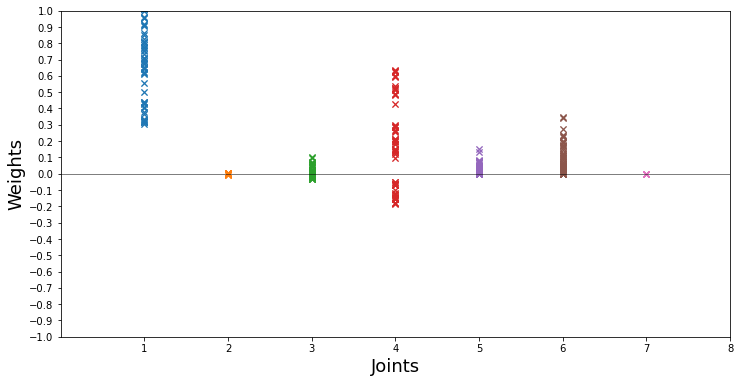

In [2]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('Joints', fontsize=18)
ax.set_ylabel('Weights', fontsize=18)
ax.set_xticks(np.arange(1,n_dof+2))
ax.set_yticks(np.arange(-1,1.1,0.1));

# weights
ones_vector = np.ones(w_arr.shape[0])
for i in range(n_dof):
    ax.plot((1+i)*ones_vector, w_arr[:,i], 'x')

# zero line
ax.plot([0, 8],[0, 0],'k',lineWidth=0.5)

plt.xlim([0,n_dof+1])
plt.ylim([-1,1])
plt.show()

#### Root locus at a particular configuration


The gain at marginal stability is 
139.27855711422845

The roots at marginal stability is 
[-2.00067532e+02+0.00000000e+00j -2.00000000e+02+0.00000000e+00j
 -2.49278504e+01+0.00000000e+00j -1.99993918e+01+0.00000000e+00j
 -2.00003041e+01-5.26761010e-04j -2.00003041e+01+5.26761010e-04j
 -2.30864287e-03+1.05691819e+01j -2.30864287e-03-1.05691819e+01j]


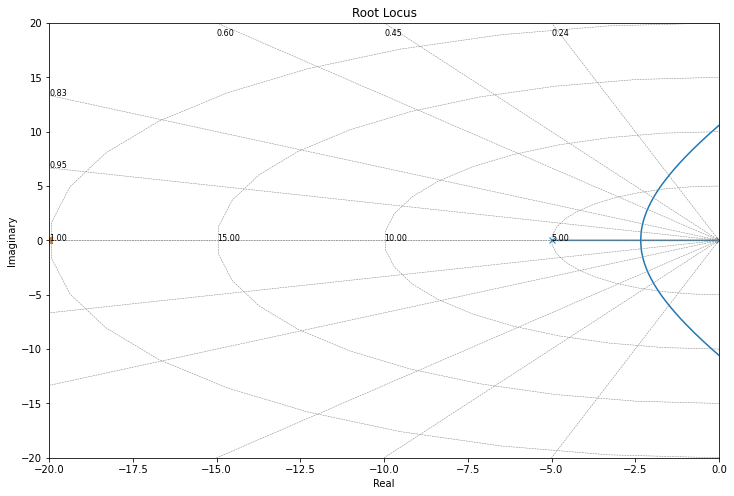

In [3]:
from control.matlab import *

# actuators
s = tf([1, 0], 1)
low_bw = 20/(s+20) # 20 Hz bw
high_bw = 200/(s+200) # 200 Hz bw
    
# alpha beta weights
alphaBeta = w_arr[10,:]

# damping
b = 5

# denominator
den = s**2 + b*s

# numerator
num = 0
for i in range(n_dof):
    if i < 4:
        act_bw = low_bw
    else:
        act_bw = high_bw    
    num += alphaBeta[i]*act_bw

# plant
G = num/den

# 1 + k_p G(s) = 0
fig, ax = plt.subplots(figsize=(12, 8))
rlist, klist = rlocus(G, xlim=[-20,0], ylim=[-20,20], kvect = np.linspace(0,500,500), plot=True)
idx = np.min(np.where(np.amax(rlist.real,axis=1) > 0))-1

# print gains
print("\nThe gain at marginal stability is \n{}".format(klist[idx]))
print("\nThe roots at marginal stability is \n{}".format(rlist[idx]))

In [4]:
# find max gains
k = np.zeros(w_arr.shape[0])
    
# run through to find the max gains
for j in range(w_arr.shape[0]):
    # alpha beta weights
    alphaBeta = w_arr[j,:]
    
    print(j)

    # accumulate numerators
    num = 0
    for i in range(n_dof):
        if i < 4:
            act_bw = low_bw
        else:
            act_bw = high_bw    
        num += alphaBeta[i]*act_bw

    # plant
    G = num/den

    # 1 + k_p G(s) = 0
    rlist, klist = rlocus(G, xlim=[-20,0], ylim=[-20,20], kvect = np.linspace(0,500,500), plot=False)
    idx = np.min(np.where(np.amax(rlist.real,axis=1) > 0))-1

    # store gains
    k[j] = klist[idx]
    
print("Gains: min = {}, mean = {}, max = {}".format(np.min(k), np.mean(k), np.max(k)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
Gains: min = 124.24849699398796, mean = 142.72294589178355, max = 203.40681362725448


$J_x = S_x X J$, $\Lambda = (J_x M^{-1} J_x^T)^{-1} = (S_x X J M^{-1} J^T X^T S_x^T)^{-1}$ where $X = \begin{bmatrix} I & \hat r_{i \rightarrow ee} \\ 0 & I \end{bmatrix}$

$\Lambda = (J_x M^{-1} J_x^T)^{-1} = (X J M^{-1} J^T X^T)^{-1}$

In [5]:
# from the paper "Operational Space Control under Actuator Bandwidth Limitation"
# from control.matlab import *
# s = tf([1, 0], 1)
# low_bw = 10/(s+10)

# num = low_bw*w1 + high_bw*w2
# den = s**2 + b*s

# high_bw = 100/(s+100)

# w1 = 0.2
# w2 = 0.8
# b = 5

# num = low_bw*w1 + high_bw*w2
# den = s**2 + b*s

# rlist, klist = rlocus(num/den, xlim=[-40, 0], ylim=[-20, 20], kvect = np.linspace(0,450,450), plot=True)
# idx = np.min(np.where(np.amax(rlist.real,axis=1) > 0))-1

# print("\nThe plant is given by \n{}".format(num/den))
# print("\nThe gain at marginal stability is \n{}".format(klist[idx]))
# print("\nCorresponding poles are at \n{}".format(rlist[idx]))


#### Lambda calculations for axis-intersecting wrist

$M^{-1} = P$ where $P = \begin{bmatrix} A \in \mathbb{S}^4_{++} & B \in \mathbb{R}^{4 \times 3} \\ B^T & C \in \mathbb{S}^3_{++} \end{bmatrix}$

$J = \begin{bmatrix} J_{vl} \in \mathbb{R}^{3 \times 4} & J_{vh} \in \mathbb{R}^{3 \times 3} \\ J_{wl} & J_{wh} \in \mathbb{R}^{3 \times 3} \end{bmatrix}$

$$\Lambda^{-1} = J M^{-1} J^T = \begin{bmatrix} J_{vl} & J_{vh} \\ J_{wl} & J_{wh} \end{bmatrix} \begin{bmatrix} A & B \\ B^T & C \end{bmatrix} \begin{bmatrix} J^T_{vl} & J^T_{wl} \\ J^T_{vh} & J^T_{wh} \end{bmatrix}$$

$$\Lambda^{-1} = \begin{bmatrix} J_{vl} A + J_{vh} B^T & J_{vl} B + J_{vh} C \\ J_{wl} A + J_{wh} B^T & J_{wl} B + J_{wh} C \end{bmatrix} \begin{bmatrix} J^T_{vl} & J^T_{wl} \\ J^T_{vh} & J^T_{wh} \end{bmatrix}$$

$$\Lambda^{-1} = \begin{bmatrix} J_{vl} A + 0 & J_{vl} B + 0 \\ J_{wl} A + J_{wh} B^T & J_{wl} B + J_{wh} C \end{bmatrix} \begin{bmatrix} J^T_{vl} & J^T_{wl} \\ 0 & J^T_{wh} \end{bmatrix}$$

$$\Lambda^{-1} = \begin{bmatrix} J_{vl} A J^T_{vl} & J_{vl} A J^T_{wl} + J_{vl} B J^T_{wh} \\ J_{wl} A J_{vl}^T + J_{wh} B^T J_{vl}^T & (J_{wl} A J_{wl}^T + J_{wh} B^T J_{wl}^T) + (J_{wl} B J_{wh}^T + J_{wh} C J_{wh}^T)  \end{bmatrix}$$